In [181]:
import os, re, json
import numpy as np

# plotting styles
import matplotlib as mpl
from matplotlib import pyplot as plt

plt.style.use("dark_background")

%matplotlib inline

mpl.rcParams['figure.dpi'] = 150
mpl.rcParams.update(
    {"font.size": 24, "font.family" : "serif", "axes.labelsize": 24, "axes.titlesize": 18, "text.usetex": True,
    "xtick.major.width": 1.5, "xtick.minor.width": 1.2, "ytick.major.width": 1.5, "ytick.minor.width": 1.2,
    "legend.fontsize": 18}
)

# change to the root folder
base_dir = "/Users/jibanmac/Documents/GitHub/gpy_dla_detection/"
os.chdir(base_dir)

try:
    assert "null_gp.py" in os.listdir("gpy_dla_detection")
except Exception as e:
    print(e)
    print(
        "[Warning] Change the directory of base_dir to the path of your gpy_dla_detection repository."
    )

In [2]:
# The test selection file includes a list of 100 quasar spectra and their redshifts
from tests import test_selection

# The module to read spectrum, which also helps us to download the file (for SDSS DR12 spectrum)
from gpy_dla_detection.read_spec import read_spec, retrieve_raw_spec


In [3]:
# My current favourite style
import arviz as az

az.style.use("arviz-viridish")


In [4]:
def download_and_read(
    plate: int,
    mjd: int,
    fiber_id: int,
):
    filename = "spec-{:d}-{:d}-{:04d}.fits".format(plate, mjd, fiber_id)

    # If we haven't downloaded the file, this cell will help you download the file from SDSS database
    if not os.path.exists(filename):
        # This line gets the plate, mjd, and fiber_id from the given filename
        # Note: re is the regex.
        plate, mjd, fiber_id = re.findall(
            r"spec-([0-9]+)-([0-9]+)-([0-9]+).fits",
            filename,
        )[0]
        # Download the file using the given plate, mjd, and fiber_id
        retrieve_raw_spec(int(plate), int(mjd), int(fiber_id))

    # make sure the file exists
    assert os.path.exists(filename) == True

    # Read the raw spectrum: This line reads the spectrum file into four numpy arrays
    wavelengths, flux, noise_variance, pixel_mask = read_spec(filename)
    # simulated data
    # you have : wavelengths (velocities), flux
    # noise_variance : you need to inject your own noise
    # pixel_mask : you don't have. pixel_mask is the invalid pixel in spectrum
    return wavelengths, flux, noise_variance, pixel_mask


In [5]:
from tests.test_zestimation import *

In [6]:
# read the first spectrum from SDSS DR12
nspec = 0

# filenames is an array for a list of spectra, and we take one of them here
filename = filenames[nspec]

filename

'spec-6173-56238-0528.fits'

In [7]:
# If we haven't downloaded the file, this cell will help you download the file from SDSS database
if not os.path.exists(filename):
    plate, mjd, fiber_id = re.findall(
        r"spec-([0-9]+)-([0-9]+)-([0-9]+).fits",
        filename,
    )[0]
    retrieve_raw_spec(int(plate), int(mjd), int(fiber_id))


In [8]:
# make sure the file exists
assert os.path.exists(filename) == True

In [9]:
# read the raw spectrum
wavelengths, flux, noise_variance, pixel_mask = read_spec(filename)

In [11]:
# Names and Rest-Wavelengths of the Emission Lines
emission_rest_wavelengths = [1215.24, 1549.48, 2799.117]
emission_names = [r"Ly$\alpha$", r"CIV", r"MgII"]

## Initialize model


In [12]:
# Initialize the model parameters
params = ZParameters()
z_qso_samples = ZSamples(params)

learned_file = "data/dr12q/processed/learned_zqso_only_model_outdata_full_dr9q_minus_concordance_norm_1176-1256.mat"

# load the model
z_qso_gp = ZGPMAT(
    params,
    z_qso_samples,
    learned_file=learned_file,
)

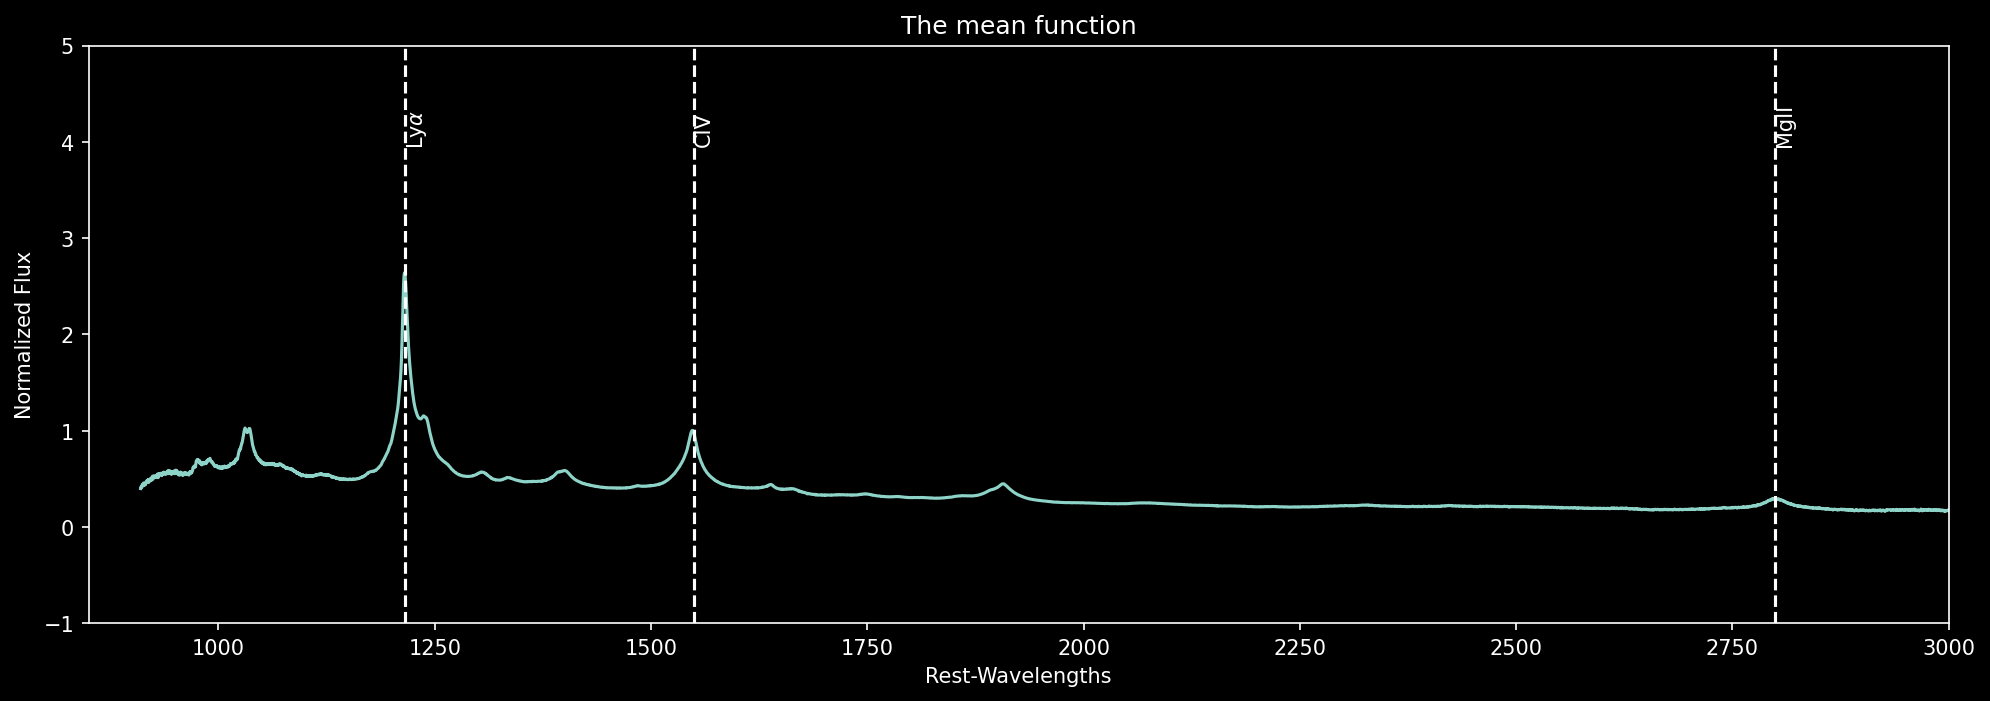

In [14]:
# Plot the model
plt.figure(figsize=(16, 5))
plt.title("The mean function")
plt.plot(z_qso_gp.rest_wavelengths, z_qso_gp.mu)
plt.ylim(-1, 5)
plt.xlim(850, 3000)
plt.xlabel("Rest-Wavelengths")
plt.ylabel("Normalized Flux")

# plot the emission lines to help measure the z
for n, w in zip(emission_names, emission_rest_wavelengths):
    plt.vlines(w, -1, 5, ls="--")
    plt.text(
        w,
        4,
        n,
        rotation="vertical",
    )


#### Inference


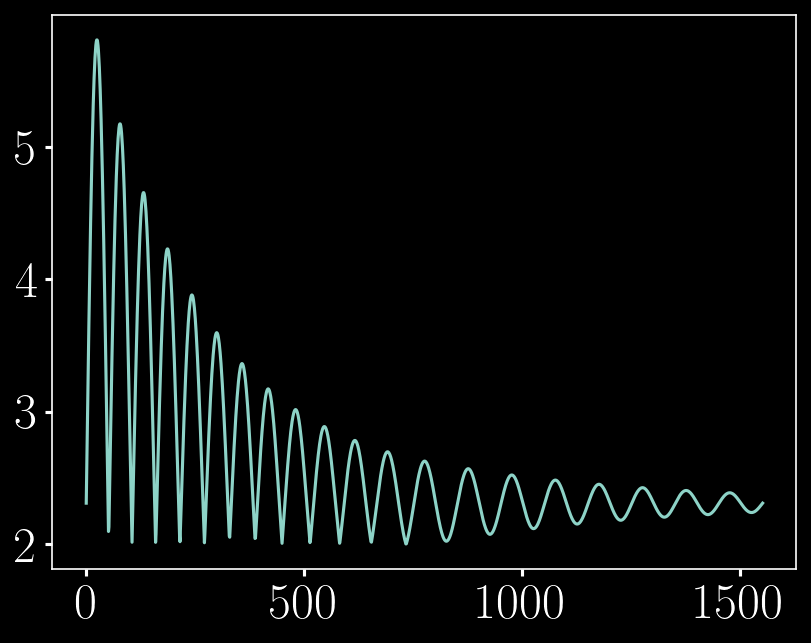

In [247]:
num_bins = 2000
freq = np.linspace(20, 20, num_bins)

test_redshifts = (
    np.sin(np.linspace(-np.pi, np.pi, num_bins) * freq)
    * 10
    * np.exp(np.linspace(-1, -5, num_bins))
    + 2.30909729
)

test_redshifts = test_redshifts[test_redshifts > 2]

plt.plot(test_redshifts)


In [248]:
# 10,000 test redshifts, from 2 ~ 5
# test_redshifts = np.linspace(2, 5, 10000)

sample_log_likelihoods = []

# loop over all of the test redshift, fit the GP to the data, get the likelihood value
for i, z_qso in enumerate(test_redshifts):
    # [fit the GP to the data] set the data and interpolate the model
    z_qso_gp.set_data(
        wavelengths,
        flux,
        noise_variance,
        pixel_mask,
        z_qso=z_qso,
        normalize=True,
        build_model=True,
    )

    # [get the likelihood value]
    sample_log_likelihoods.append(z_qso_gp.log_model_evidence())


In [249]:
sample_log_likelihoods = np.array(sample_log_likelihoods)


In [241]:
# gp samples
gp_samples = np.random.multivariate_normal(z_qso_gp.mu, z_qso_gp.K, size=1000)


In [281]:
def make_plot(
    test_z_qso: np.ndarray, sample_log_likelihoods: np.ndarray, z_qso=2.30909729
):
    # read spec
    wavelengths, flux, noise_variance, pixel_mask = read_spec(filename)
    pixel_mask[1893:1899] = True

    # z_qso = spec_dict["z_qso"]
    rest_wavelengths = wavelengths / (1 + z_qso)

    # "The zQSO" to plot
    this_z_qso = test_z_qso[-1]
    this_log_likelihoods = sample_log_likelihoods[-1]

    # rebuild model
    z_qso_gp.set_data(
        wavelengths,
        flux,
        noise_variance,
        pixel_mask,
        z_qso=this_z_qso,
        normalize=True,
        build_model=True,
    )

    ################### Plotting the model ###################
    fig, axs = plt.subplots(2, 1, figsize=(16, 7))
    ax = axs[0]

    # from blue to red
    redshift_color = "C2"
    model_color = "C1"

    # plotting normalization
    normalization = 0

    # Rest-frame flux
    ax.plot(
        rest_wavelengths[~pixel_mask],  # quasar spectrum's rest-frame wavelengths
        flux[~pixel_mask] + normalization,  # quasar spectrum's flux
        label="Data",
        color=redshift_color,
        lw=0.1,
        alpha=0.9,
    )
    ax.fill_between(
        rest_wavelengths[~pixel_mask],
        -0.5,
        flux[~pixel_mask] + normalization,
        label="SDSS Instrumental Uncertainty (95%)",
        color=redshift_color,
        alpha=0.6,
    )

    # redshift model
    ax.plot(
        z_qso_gp.rest_wavelengths * (1 + z_qso) / (1 + this_z_qso),
        z_qso_gp.mu + normalization,
        label="GP null model (mu = continuum)",
        color=model_color,
        # ls="--",
        linewidth=2.4,
        alpha=0.9,
    )
    # GP samples
    nsamples = gp_samples.shape[0]
    ax.plot(
        z_qso_gp.rest_wavelengths * (1 + z_qso) / (1 + this_z_qso),
        gp_samples[np.random.randint(0, nsamples), :] + normalization,
        color=model_color,
        # ls="--",
        linewidth=1.8,
        alpha=0.9,
    )
    # ax.fill_between(
    #     z_qso_gp.rest_wavelengths * (1 + z_qso) / (1 + this_z_qso),
    #     gp_samples[np.random.randint(0, nsamples)] + normalization,
    #     z_qso_gp.mu + normalization,
    #     color=model_color,
    #     alpha=0.1,
    # )

    ax.set_xlabel("Rest-frame Wavelengths [$\AA$]", fontdict={"fontsize": 24})
    # ax.set_ylabel("Normalized Flux")
    ax.set_xlim(850, 3000)
    ax.set_ylim(-0.5, 3)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # ax.text(
    #     4600,
    #     4,
    #     "$z_{QSO}$ = " + "{:.4g};".format(this_z_qso),
    #     fontdict={"fontsize": 20},
    # )

    # ax.axis("off")
    ax.set(yticklabels=[])
    fig.tight_layout()

    ############# Likelihood ##############
    ax = axs[1]
    for i in range(len(test_z_qso) - 1):
        ax.plot(
            test_z_qso[i:],
            sample_log_likelihoods[i:],
            color=model_color,
            lw=6 * (i / len(test_z_qso) + 0.1),
            alpha=0.4,
        )
    ax.scatter(
        test_z_qso[-1],
        sample_log_likelihoods[-1],
        color=model_color,
        marker="o",
        s=90,
        # alpha=0.4,
    )

    ax.set_xlabel("$z_{QSO}$", fontsize=24)
    ax.set_ylabel(
        "Log Likelihood",
        fontsize=24,
    )
    ax.set_ylim(sample_log_likelihoods.min() - 100, 0)

    ax.vlines(
        z_qso,
        sample_log_likelihoods.min() - 100,
        0,
        ls="--",
    )
    ax.yaxis.set_label_position("right")

    ax.set_xlim(
        np.min([z_qso, test_z_qso.min()]) - 0.5, np.max([z_qso, test_z_qso.max() + 0.5])
    )
    # fig.savefig(
    #     "cover_photos/demo_spec_{}_snr_35.png".format(k), dpi=150, transparent=True
    # )
    # fig.tight_layout()
    return fig, ax

(<Figure size 2400x1050 with 2 Axes>,
 <AxesSubplot:xlabel='$z_{QSO}$', ylabel='Log Likelihood'>)

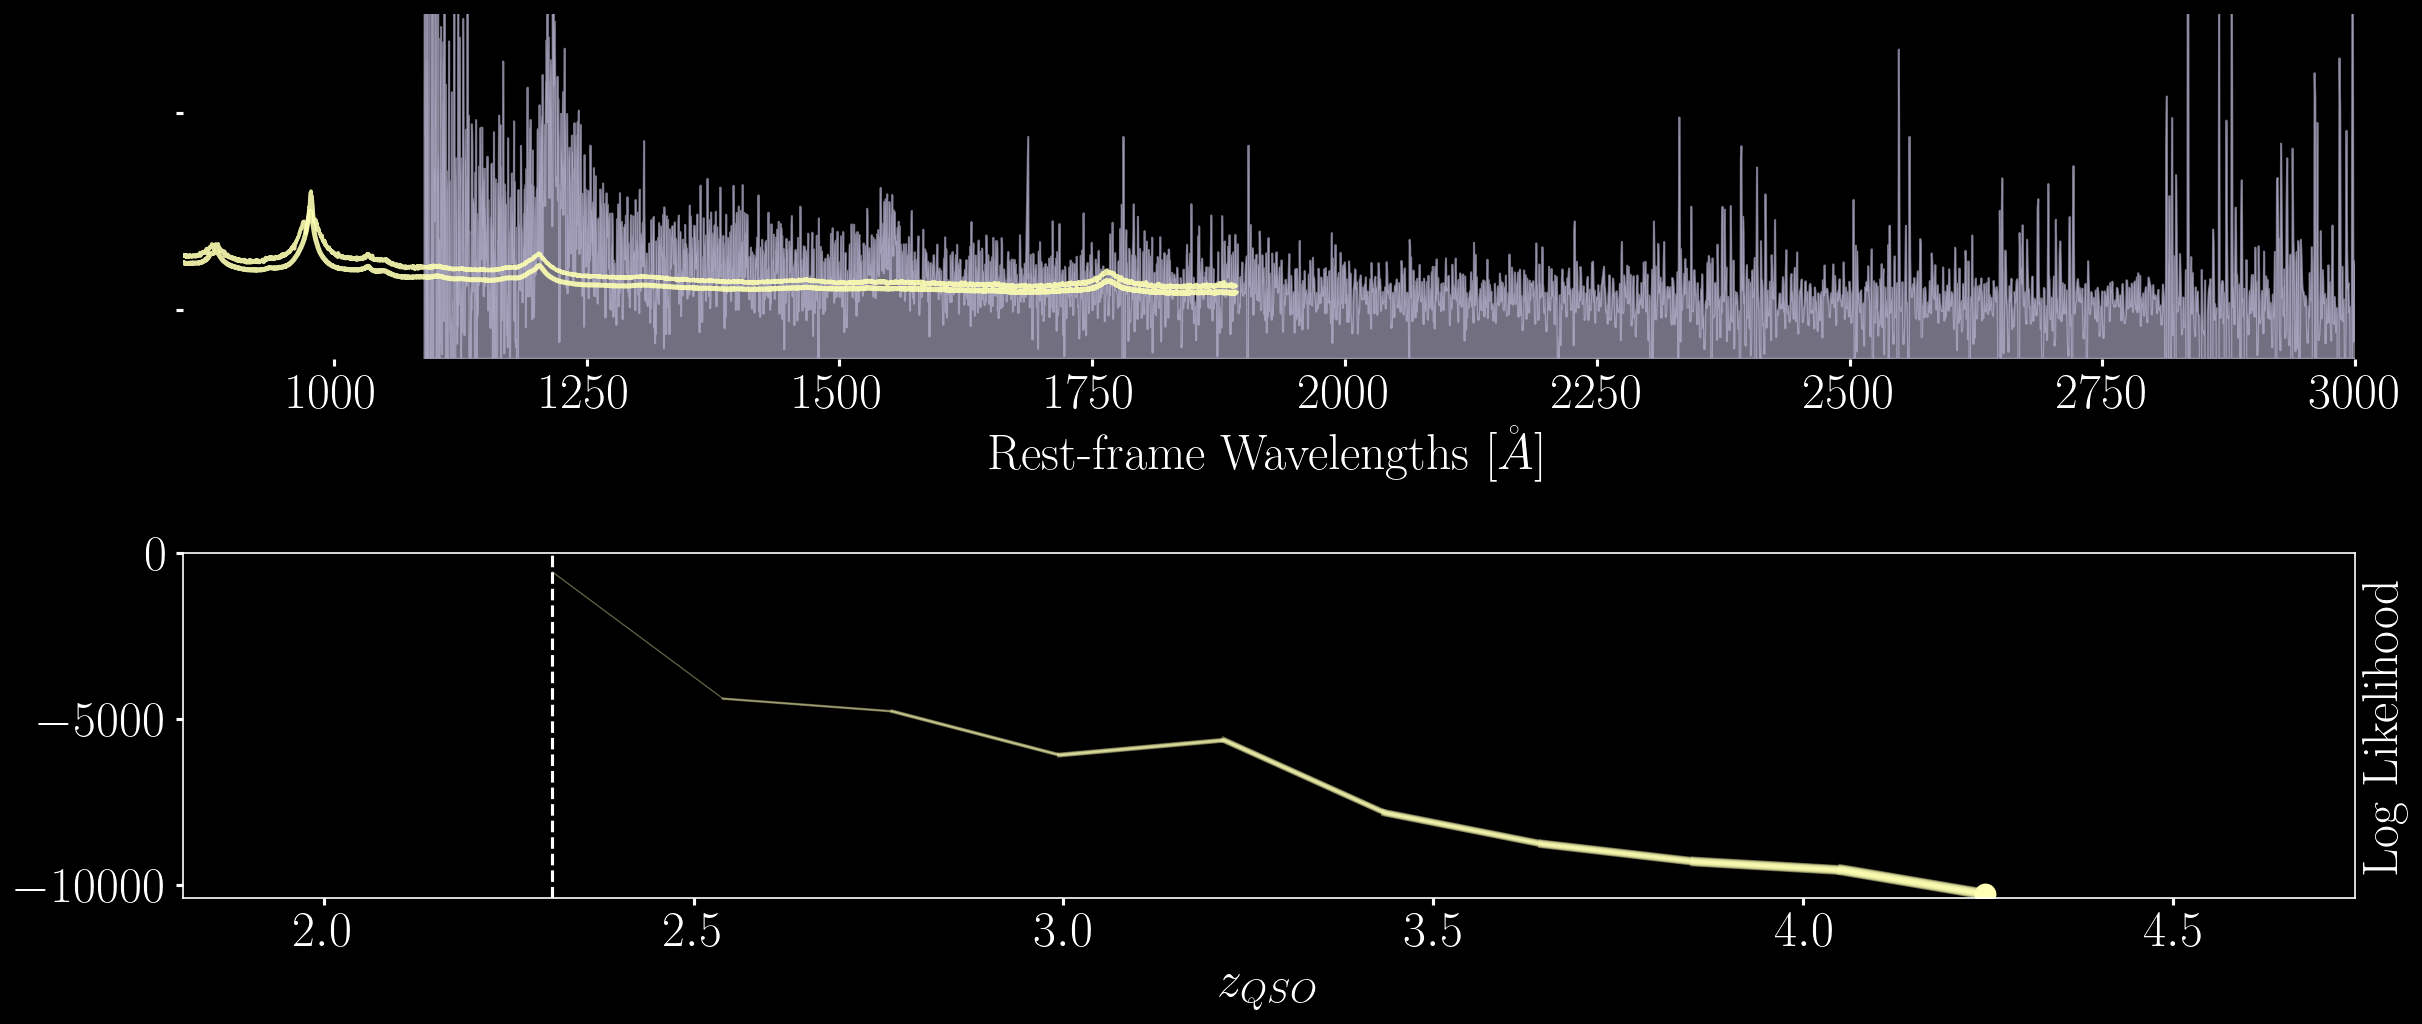

In [282]:
make_plot(
    test_z_qso=test_redshifts[:10],
    sample_log_likelihoods=sample_log_likelihoods[:10],
    z_qso=z_qso,
)


In [283]:
length = len(test_redshifts)
period_length = 20

for i in range(2, length):
    istart = np.clip(i - period_length, a_min=0, a_max=length)
    fig, ax = make_plot(
        test_z_qso=test_redshifts[istart:i],
        sample_log_likelihoods=sample_log_likelihoods[istart:i],
        z_qso=z_qso,
    )
    fig.savefig(
        "zqso_animation/zqso_{}.png".format(str(i).zfill(4)),
        dpi=100,
        # transparent=True,
    )
    plt.close()
    plt.clf()

<Figure size 960x720 with 0 Axes>